## <u>Load InceptionV3</u>


In [7]:
# import modules
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras import backend as K

conv_base = InceptionV3(weights='imagenet', input_shape=(299, 299, 3), include_top=False, pooling='max', classes=5)

In [8]:
from keras import models
from keras import layers
from keras import regularizers

# create pre-trained CNN architecture
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(5, activation='softmax'))

model.summary()

# source/credit : https://www.kaggle.com/arsenyinfo/f-beta-score-for-keras
# code for calculating the F1 metric
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    y_pred = K.clip(y_pred, 0, 1)
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 21,813,029.0
Trainable params: 21,778,597.0
Non-trainable params: 34,432.0
_________________________________________________________________


#### Define image generators and common parameters

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 20
target_size = (299, 299)
epochs = 30

train_generator = train_datagen.flow_from_directory(
    'diabetic/processed_images/train',
    target_size=target_size,
    classes=['0', '1', '2', '3', '4'],
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'diabetic/processed_images/validation',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 30000 images belonging to 5 classes.
Found 5120 images belonging to 5 classes.


## <u>Training</u>

Class weights (`class_weight={0: 1, 1: 10.6, 2: 4.6, 3: 30, 4: 37},`) are calculated according to the ratio of available training images for each class for tackling the **class imbalance problem**. The number of images per class available for training:

* Normal (0) - 25807 images (73.48%) 
* Mild (1) - 2442 images (6.96%) 
* Moderate (2) - 5291 images (15.07%) 
* Severe (3) - 873 images (2.48%)
* Proliferative (4) -708 images(2.01%)

The model is trained with 

In [4]:
# compile the model and train
model.compile(loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc', fbeta])

history = model.fit_generator(
    train_generator,
    class_weight={0: 1, 1: 10.6, 2: 4.6, 3: 30, 4: 37},
    steps_per_epoch = 100,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = 100)

Epoch 1/30
100/100 [==============================] - 102s - loss: 8.4687 - acc: 0.2270 - fbeta: 0.1840 - val_loss: 1.2536 - val_acc: 0.5820 - val_fbeta: 0.5736
Epoch 2/30
100/100 [==============================] - 98s - loss: 7.3679 - acc: 0.2990 - fbeta: 0.2552 - val_loss: 1.2725 - val_acc: 0.6130 - val_fbeta: 0.6062
Epoch 3/30
100/100 [==============================] - 98s - loss: 6.5294 - acc: 0.3155 - fbeta: 0.2696 - val_loss: 1.2670 - val_acc: 0.5935 - val_fbeta: 0.5851
Epoch 4/30
100/100 [==============================] - 98s - loss: 7.5591 - acc: 0.2895 - fbeta: 0.2543 - val_loss: 1.1638 - val_acc: 0.6600 - val_fbeta: 0.6562
Epoch 5/30
100/100 [==============================] - 98s - loss: 6.5905 - acc: 0.3380 - fbeta: 0.2815 - val_loss: 1.1450 - val_acc: 0.6415 - val_fbeta: 0.6344
Epoch 6/30
100/100 [==============================] - 98s - loss: 6.3315 - acc: 0.3555 - fbeta: 0.3036 - val_loss: 1.1149 - val_acc: 0.6930 - val_fbeta: 0.6886
Epoch 7/30
100/100 [===================

## <u>Visualizing loss and accuracy</u>

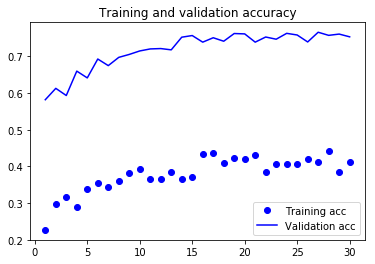

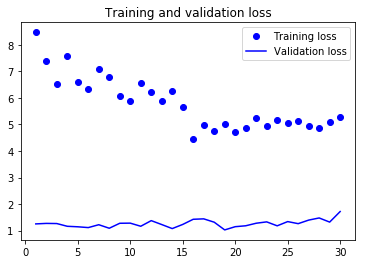

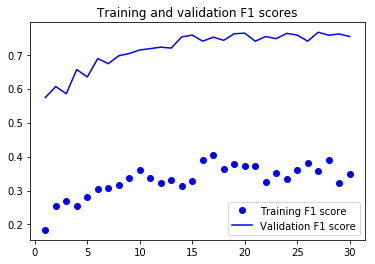

In [5]:
import h5py
import matplotlib.pyplot as plt

# save model and weight for future training
model.save("inceptionV3.model")
model.save('saved_models/inceptionV3.h5')
model.save_weights('saved_models/inceptionV3-weights.h5', overwrite=True)
json_string = model.to_json()

with open('saved_models/inceptionV3.json', 'w') as f:
      f.write(json_string)

# define variables for plotting
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['fbeta']
val_f1 = history.history['val_fbeta']
epochs = range(1, len(acc) + 1)

# plot graphs for loss, accuracy and F1 score
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, f1, 'bo', label='Training F1 score')
plt.plot(epochs, val_f1, 'b', label='Validation F1 score')
plt.title('Training and validation F1 scores')
plt.legend()
plt.show()


In [ ]:
# backup
# preds = pd.read_csv(os.path.join('submission_backup.csv'))

# def get_labels(directory):
#     return os.listdir(directory)

# idx_label =  get_labels(os.path.abspath(os.path.join('diabetic/processed_images/test')))

# len(idx_label)
# print(idx_label[0])
# print(os.path.splitext(idx_label)[0])

In [ ]:
# from __future__ import absolute_import
# import pandas as pd
# import matplotlib.pyplot as plt
# import os
# %matplotlib inline




# l = os.listdir('diabetic/processed_images/test')
# idx_label = [x.split('.')[0] for x in l]

# len(idx_label)
# idx_label

In [ ]:
# pd.DataFrame(idx_label)

In [ ]:
# preds['image'] = idx_label
# print(preds)

## <u>Predict 53, 576 testing images</u>

In [108]:
# run prediction on testing dataset of 53,576 images
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import os
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

if __name__ == "__main__":

    model.load_weights('saved_models/inceptionV3-weights.h5')    
    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
# Single Image
#     img_path = image.load_img('sample/test2/38016_right.jpeg', target_size=(224, 224))
#     x = image.img_to_array(img_path)
#     x = np.expand_dims(x, axis=0)

#     filenames = sample_generator.filenames
#     nb_samples = len(filenames)
#     print(nb_samples)
#     prediction = model.predict_generator(sample_generator, steps = 17)
#     print prediction

# create test data generators
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'diabetic/processed_images/test',
        target_size=(299, 299),
        shuffle = "false",
        class_mode=None,
        batch_size=1)

filenames = test_generator.filenames
    nb_samples = len(filenames)
    
    predicted_classes = np.argmax(test_generator)
    true_classes = test_generator.classes
    predict = model.predict_generator(test_generator, steps = nb_samples, verbose=1)

    print(predict.argmax(axis=-1).astype(int))

    # output predictions to csv file (submission.csv)
    def save_to_csv():
        df = pd.read_csv("submission.csv")
        df['prediction'] = predict.argmax(axis=-1).astype(float)
        df.to_csv('submission2.csv', index=False)

    save_to_csv()



Found 53576 images belonging to 1 classes.
53575/53576 [============================>.] - ETA: 0s[0 0 0 ... 0 2 0]
